http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV

In [2]:
movies = pd.read_csv('data/movies.csv')

In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [4]:
ratings =pd.read_csv('data/ratings.csv')

In [25]:
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
df= ratings.merge(movies,on='movieId', how='left')
df.head()


,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [7]:
df = df.drop(columns='timestamp')

In [9]:
df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [10]:

# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596]]

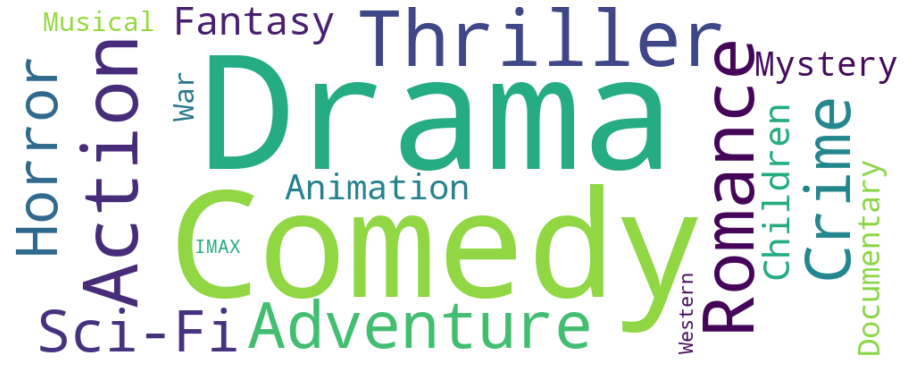

In [17]:

genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [18]:
rate = df['rating'].value_counts().sort_index(ascending=False)

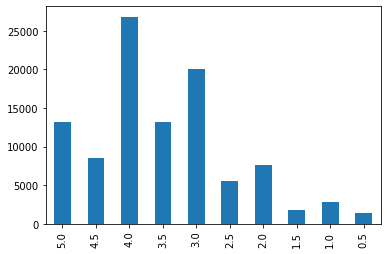

In [20]:
rate.plot(kind="bar")

# Surprise

In [26]:
ratings_df = ratings.drop(columns='timestamp') 

In [27]:
from surprise import Reader, Dataset
reader = Reader()
data = Dataset.load_from_df(ratings_df, reader)
# loooks like load from df is looking for hte uid, iid, and r values as the columns
# Need to make sure they are in the right order!!!

In [28]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  610 

Number of items:  9724


In [30]:
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

In [31]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8691880993739683, 'mae': 0.6683788618971274}
{'rmse': {'n_factors': 100, 'reg_all': 0.05}, 'mae': {'n_factors': 100, 'reg_all': 0.05}}


In [32]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(weights='distance')


In [33]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.97090423, 0.96812232, 0.97408227, 0.98207434, 0.96930335]))
('test_mae', array([0.7488049 , 0.74796538, 0.75067068, 0.76042204, 0.74914571]))
('fit_time', (0.6365649700164795, 0.8314712047576904, 0.7698040008544922, 0.8615469932556152, 0.6030988693237305))
('test_time', (2.044965982437134, 2.531765937805176, 2.110797882080078, 1.9383678436279297, 1.5302889347076416))
-----------------------
0.9728973026812596


In [34]:
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [35]:
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([0.87636725, 0.87665162, 0.87860245, 0.87350928, 0.87990275]))
('test_mae', array([0.66972606, 0.67159666, 0.66650428, 0.66749758, 0.67081533]))
('fit_time', (0.9726541042327881, 1.0981512069702148, 0.9826571941375732, 1.0164542198181152, 1.1503407955169678))
('test_time', (3.076253890991211, 2.7450077533721924, 2.447953939437866, 2.778855800628662, 2.647739887237549))


0.8770066692056611

In [36]:
svd = SVD(n_factors=50, reg_all=0.05)

In [37]:
svd.fit(dataset)

In [38]:
svd.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=2.9297133303078358, details={'was_impossible': False})

In [39]:
user_rating = [{'userId': 1000, 'movieId': 55245, 'rating': '5'},
 {'userId': 1000, 'movieId': 2491, 'rating': '4'},
 {'userId': 1000, 'movieId': 4718, 'rating': '4'},
 {'userId': 1000, 'movieId': 4718, 'rating': '5'},
 {'userId': 1000, 'movieId': 5990, 'rating': '3'}]

In [40]:
new_ratings_df = ratings_df.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [41]:
svd_ = SVD(n_factors= 100, reg_all=0.05)
svd_.fit(new_data.build_full_trainset())

In [42]:
list_of_movies = []
for m_id in ratings_df['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(1000,m_id)[3]))

In [43]:
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)


In [44]:
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_movies(ranked_movies,movies,5)

Recommendation #  1 :  680    Philadelphia Story, The (1940)
Name: title, dtype: object 

Recommendation #  2 :  704    Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
Name: title, dtype: object 

Recommendation #  3 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation #  4 :  929    Raging Bull (1980)
Name: title, dtype: object 

Recommendation #  5 :  659    Godfather, The (1972)
Name: title, dtype: object 



## SKlearn

In [46]:
ratings_df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [47]:
movie_df = movies.drop(columns = 'genres')

In [49]:
#merge ratings with movie titles
df = pd.merge(ratings_df, movie_df, on='movieId')

In [50]:
df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [51]:
movie_ratingCount = df.groupby(by= ['title'])['rating'].count().reset_index().rename(columns = {'rating': 'totalRatingCount'})[['title', 'totalRatingCount']]


In [52]:
movie_ratingCount.head()

,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


In [54]:
rating_with_totalRatingCount = df.merge(movie_ratingCount,
                                        left_on = 'title', right_on = 'title', how='left')

In [55]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(movie_ratingCount.describe())

       totalRatingCount
count          9719.000
mean             10.375
std              22.406
min               1.000
25%               1.000
50%               3.000
75%               9.000
max             329.000


In [56]:
popularity_threshhold = 50
rating_popular_movie = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshhold')


In [58]:
rating_popular_movie.shape

(41362, 5)

In [59]:
average_ratings = df.groupby(by= ['userId'])['rating'].mean().reset_index().rename(columns = {'rating': 'avg_rating'})[['userId', 'avg_rating']]

In [61]:
average_ratings.head()

,userId,avg_rating
0,1,4.366
1,2,3.948
2,3,2.436
3,4,3.556
4,5,3.636


In [62]:
movie_features_df = rating_popular_movie.pivot_table(index = 'userId', columns='title', values = 'rating')

In [63]:
movie_features_df

title,10 Things I Hate About You (1999),12 Angry Men (1957),2001: A Space Odyssey (1968),28 Days Later (2002),300 (2007),"40-Year-Old Virgin, The (2005)",A.I. Artificial Intelligence (2001),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),...,Willy Wonka & the Chocolate Factory (1971),"Wizard of Oz, The (1939)","Wolf of Wall Street, The (2013)",X-Men (2000),X-Men: The Last Stand (2006),X2: X-Men United (2003),You've Got Mail (1998),Young Frankenstein (1974),Zombieland (2009),Zoolander (2001)
userId,,,,,,,,,,,,,,,,,,,,,
1,nan,nan,nan,nan,nan,nan,nan,4.000,nan,nan,...,5.000,5.000,nan,5.000,nan,nan,nan,5.000,nan,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,5.000,nan,nan,nan,nan,nan,3.000,nan
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,0.500,nan,nan,nan
4,nan,5.000,nan,nan,nan,nan,nan,nan,nan,nan,...,4.000,5.000,nan,nan,nan,nan,nan,nan,nan,nan
5,nan,nan,nan,nan,nan,nan,nan,nan,3.000,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,nan,nan,5.000,nan,nan,nan,3.500,nan,nan,2.000,...,nan,nan,nan,nan,nan,nan,3.500,3.500,nan,nan
607,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,5.000,nan,3.000,nan,nan,nan,nan,nan,nan
608,nan,nan,3.000,3.500,5.000,nan,4.500,3.000,3.500,2.000,...,3.500,2.500,nan,4.000,4.000,4.000,nan,nan,nan,3.000


In [64]:
rating_with_totalRatingCount_and_avg = movie_features_df.merge(average_ratings,
                                        left_on = 'userId', right_on = 'userId', how='left')

In [65]:
rating_with_totalRatingCount_and_avg

,userId,10 Things I Hate About You (1999),12 Angry Men (1957),2001: A Space Odyssey (1968),28 Days Later (2002),300 (2007),"40-Year-Old Virgin, The (2005)",A.I. Artificial Intelligence (2001),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),...,"Wizard of Oz, The (1939)","Wolf of Wall Street, The (2013)",X-Men (2000),X-Men: The Last Stand (2006),X2: X-Men United (2003),You've Got Mail (1998),Young Frankenstein (1974),Zombieland (2009),Zoolander (2001),avg_rating
0,1,nan,nan,nan,nan,nan,nan,nan,4.000,nan,...,5.000,nan,5.000,nan,nan,nan,5.000,nan,nan,4.366
1,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,5.000,nan,nan,nan,nan,nan,3.000,nan,3.948
2,3,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,0.500,nan,nan,nan,2.436
3,4,nan,5.000,nan,nan,nan,nan,nan,nan,nan,...,5.000,nan,nan,nan,nan,nan,nan,nan,nan,3.556
4,5,nan,nan,nan,nan,nan,nan,nan,nan,3.000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,606,nan,nan,5.000,nan,nan,nan,3.500,nan,nan,...,nan,nan,nan,nan,nan,3.500,3.500,nan,nan,3.657
602,607,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,5.000,nan,3.000,nan,nan,nan,nan,nan,nan,3.786
603,608,nan,nan,3.000,3.500,5.000,nan,4.500,3.000,3.500,...,2.500,nan,4.000,4.000,4.000,nan,nan,nan,3.000,3.134
604,609,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.270


In [66]:
rating_with_totalRatingCount_and_avg.set_index('userId', inplace=True)

In [67]:
rating_with_totalRatingCount_and_avg

,10 Things I Hate About You (1999),12 Angry Men (1957),2001: A Space Odyssey (1968),28 Days Later (2002),300 (2007),"40-Year-Old Virgin, The (2005)",A.I. Artificial Intelligence (2001),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),...,"Wizard of Oz, The (1939)","Wolf of Wall Street, The (2013)",X-Men (2000),X-Men: The Last Stand (2006),X2: X-Men United (2003),You've Got Mail (1998),Young Frankenstein (1974),Zombieland (2009),Zoolander (2001),avg_rating
userId,,,,,,,,,,,,,,,,,,,,,
1,nan,nan,nan,nan,nan,nan,nan,4.000,nan,nan,...,5.000,nan,5.000,nan,nan,nan,5.000,nan,nan,4.366
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,5.000,nan,nan,nan,nan,nan,3.000,nan,3.948
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,0.500,nan,nan,nan,2.436
4,nan,5.000,nan,nan,nan,nan,nan,nan,nan,nan,...,5.000,nan,nan,nan,nan,nan,nan,nan,nan,3.556
5,nan,nan,nan,nan,nan,nan,nan,nan,3.000,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,nan,nan,5.000,nan,nan,nan,3.500,nan,nan,2.000,...,nan,nan,nan,nan,nan,3.500,3.500,nan,nan,3.657
607,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,5.000,nan,3.000,nan,nan,nan,nan,nan,nan,3.786
608,nan,nan,3.000,3.500,5.000,nan,4.500,3.000,3.500,2.000,...,2.500,nan,4.000,4.000,4.000,nan,nan,nan,3.000,3.134


In [68]:
scaled_rating_with_totalRatingCount_and_avg = rating_with_totalRatingCount_and_avg.apply(lambda rating : rating - rating_with_totalRatingCount_and_avg.avg_rating)

In [69]:
scaled_rating_with_totalRatingCount_and_avg.drop(columns='avg_rating', inplace=True)

In [70]:
scaled_rating_with_totalRatingCount_and_avg.fillna(0, inplace=True)

In [71]:
new_features_df = scaled_rating_with_totalRatingCount_and_avg

In [72]:
new_features_df

,10 Things I Hate About You (1999),12 Angry Men (1957),2001: A Space Odyssey (1968),28 Days Later (2002),300 (2007),"40-Year-Old Virgin, The (2005)",A.I. Artificial Intelligence (2001),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),...,Willy Wonka & the Chocolate Factory (1971),"Wizard of Oz, The (1939)","Wolf of Wall Street, The (2013)",X-Men (2000),X-Men: The Last Stand (2006),X2: X-Men United (2003),You've Got Mail (1998),Young Frankenstein (1974),Zombieland (2009),Zoolander (2001)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.366,0.000,0.000,...,0.634,0.634,0.000,0.634,0.000,0.000,0.000,0.634,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,1.052,0.000,0.000,0.000,0.000,0.000,-0.948,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,-1.936,0.000,0.000,0.000
4,0.000,1.444,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.444,1.444,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.636,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000,0.000,1.343,0.000,0.000,0.000,-0.157,0.000,0.000,-1.657,...,0.000,0.000,0.000,0.000,0.000,0.000,-0.157,-0.157,0.000,0.000
607,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.214,0.000,-0.786,0.000,0.000,0.000,0.000,0.000,0.000
608,0.000,0.000,-0.134,0.366,1.866,0.000,1.366,-0.134,0.366,-1.134,...,0.366,-0.634,0.000,0.866,0.866,0.866,0.000,0.000,0.000,-0.134


In [73]:
movie_features_df.fillna(0, inplace=True)

In [74]:
from scipy.sparse import csr_matrix
movie_features_df_matrix = csr_matrix(new_features_df.values)

In [75]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [76]:
distance, indices = model_knn.kneighbors(new_features_df.iloc[5].values.reshape(1,-1), n_neighbors = 6)

In [77]:
def get_new_movies(userId, friendId):
    different_movies = []
    for movie, rating in new_features_df.iloc[userId].items():
        if rating == 0:
            for movie2, rating2 in new_features_df.iloc[friendId].items():
                if movie == movie2 and rating2 > 0:
                    different_movies.append(movie)
    return different_movies


In [78]:
new_movies = []
for user in indices[0][1::]:
    new_movies += get_new_movies(indices[0][0], user)

In [79]:
list(set(new_movies))[0:5]

['Demolition Man (1993)',
 'Clueless (1995)',
 'Quiz Show (1994)',
 'Beverly Hills Cop III (1994)',
 'Pocahontas (1995)']

In [80]:
def score_movie(userId, movie_title):
    df_seen_movie = new_features_df.loc[new_features_df[movie_title] != 0]
    sparse_matrix = csr_matrix(df_seen_movie.values)
    knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    model_knn.fit(sparse_matrix)
    scores = []
    if new_features_df.reset_index().loc[new_features_df.reset_index()['userId']==userId][movie_title].values[0] != 0:
        distance, indices = model_knn.kneighbors(new_features_df.reset_index().loc[new_features_df.reset_index().userId == userId].drop(columns='userId').values.reshape(1,-1), n_neighbors = 6)
        # Not WORKING????
        #         np.delete(indices, 0)
        for index in indices:
            scores.append(df_seen_movie.iloc[index][movie_title])
    else:
        distance, indices = model_knn.kneighbors(new_features_df.reset_index().loc[new_features_df.reset_index().userId == userId].drop(columns='userId').values.reshape(1,-1), n_neighbors = 5)
        for index in indices:
            scores.append(df_seen_movie.iloc[index][movie_title])
    return scores[0].mean() + average_ratings.loc[average_ratings.userId == userId]['avg_rating']

In [81]:
score_movie(4, 'Wizard of Oz, The (1939)')

3   4.404
Name: avg_rating, dtype: float64

In [82]:
df_seen_movie = new_features_df.loc[new_features_df['Wizard of Oz, The (1939)'] != 0]

In [83]:
df_seen_movie.reset_index(inplace=True)

In [84]:
average_ratings.loc[average_ratings.userId==137]['avg_rating']

136   3.979
Name: avg_rating, dtype: float64

In [92]:
df.title.value_counts()

Forrest Gump (1994)                                                                                          329
Shawshank Redemption, The (1994)                                                                             317
Pulp Fiction (1994)                                                                                          307
Silence of the Lambs, The (1991)                                                                             279
Matrix, The (1999)                                                                                           278
                                                                                                            ... 
Güeros (2014)                                                                                                  1
Saving Christmas (2014)                                                                                        1
Crimson Rivers 2: Angels of the Apocalypse (Rivières pourpres II - Les anges de l'apocalypse, Le

In [93]:
unweighted_ratings=rating_with_totalRatingCount_and_avg.fillna(0)

In [94]:
test_df=unweighted_ratings[unweighted_ratings['Forrest Gump (1994)']!=0]

In [106]:
def get_predictions(movie_title,test_df): 

    predictions=[]
    for user in test_df[movie_title].index:
        predictions.append(score_movie(user,movie_title).values[0])
    return predictions
            
   
   

In [107]:
get_predictions('Pulp Fiction (1994)', test_df)

[4.832918751867474,
 2.472409797556314,
 4.1652314535920425,
 4.580274556988738,
 2.881552141895261,
 4.087766481942014,
 3.254252090224729,
 3.77201852089543,
 3.4623872926950283,
 5.244360744555431,
 4.8293035881530235,
 3.9581827578451283,
 3.0575350356378315,
 3.187190102660095,
 4.231997493227584,
 4.418293989960657,
 4.288166863712794,
 4.243900105389704,
 3.634208459338746,
 4.637121048141891,
 3.7873009916329248,
 4.97748447204969,
 3.819284636931696,
 3.6616724853023577,
 4.910953296740277,
 3.5181769311288758,
 5.366897117763386,
 3.3678456431787427,
 4.758673379971879,
 4.13587196979033,
 5.21105382516897,
 3.2010133948177426,
 4.242716914086017,
 4.7227732966751255,
 4.866889607306274,
 5.42851188055203,
 4.71077120190583,
 4.9295421895465115,
 5.055976143103554,
 4.1709797636883925,
 3.6740717106114467,
 5.221243700449236,
 5.093550980533234,
 4.86572969404112,
 4.384294387079079,
 3.5055914292548,
 3.3543192918192917,
 4.3134112566193,
 3.4003066560408732,
 4.253523192472

In [108]:
def get_rmse(movie_title):
    
    test_df=unweighted_ratings[unweighted_ratings[movie_title]!=0]
    test_answers=test_df[movie_title]
    pred=get_predictions(movie_title, test_df)
    ans= test_answers.values
    return np.sqrt(mean_squared_error(ans,pred))

In [109]:
get_rmse('Forrest Gump (1994)')

0.5705741694545059

In [110]:
get_rmse('Pulp Fiction (1994)')

0.5754204833141631